In [41]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

# Define Tickers and Time Period

In [42]:
# define the list of tickers
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [43]:
# set the end date to today
end_date = datetime.now()
# set the start date to 5 years ago
start_date = end_date - timedelta(days=365*5)
#end_date, start_date

# Download (Adjusted) Close Prices

In [44]:
adj_close_df = pd.DataFrame() 
for ticker in tickers:
    # Download the data
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    # Use the adjusted close prices
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [45]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2020-08-03  306.142303  77.136803  185.639999  261.580048  155.199707
2020-08-04  307.324829  77.300964  189.589996  262.551056  155.813202
2020-08-05  309.233704  77.197304  191.350006  263.201691  156.947281
2020-08-06  311.300751  77.318260  193.889999  266.687744  157.709518
2020-08-07  311.524200  77.231842  190.809998  263.609497  157.839661
...                ...        ...         ...         ...         ...
2025-07-28  636.940002  72.758659  305.410004  568.140015  313.600006
2025-07-29  635.260010  73.137398  306.250000  567.260010  312.609985
2025-07-30  634.460022  72.948036  300.959991  568.020020  312.250000
2025-07-31  632.080017  72.957993  302.959991  565.010010  310.890015
2025-08-01  621.719971  73.589996  309.109985  553.880005  305.739990

[1256 rows x 5 columns]


# Calculate Lognormal Returns

In [46]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()

# Calculate Covariance Matrix

In [47]:
cov_matrix = log_returns.cov() * 252  # Annualize the covariance matrix

In [48]:
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.030587  0.001909  0.003637  0.038281  0.031063
BND  0.001909  0.003594  0.003157  0.002739  0.002000
GLD  0.003637  0.003157  0.023884  0.004884  0.003792
QQQ  0.038281  0.002739  0.004884  0.054354  0.038951
VTI  0.031063  0.002000  0.003792  0.038951  0.031877


# Define Portfolio Performance Metrics

In [49]:
# calculate the portfolio standard deviation
def standard_deviation (wieghts, cov_matrix):
    variance = wieghts.T @ cov_matrix @ wieghts
    return np.sqrt(variance)

In [50]:
# calculate the expected return
# *key assumption: the expected return are based on historical returns
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252  # Annualize the returns

# Calculate the Sharpe Ratio
Sharpe Ratio = (Portfolio Return - Risk-Free Rate) / Standard Deviation

The Risk Free Rate (rf) is the theoretical rate of return received on zero-risk assets, which serves as the minimum return required on riskier investments


In [51]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

# Portfolio Optimisation

We'll use the FRED API to get the risk-free rate (10-year Treasury rate). The API key is stored securely in an environment file.

In [52]:
%pip install fredapi python-dotenv
from fredapi import Fred
import os
from dotenv import load_dotenv

Note: you may need to restart the kernel to use updated packages.


In [53]:
# Load environment variables from .env file
load_dotenv()

# Get the FRED API key from environment variables
api_key = os.getenv('FRED_API_KEY')
if not api_key:
    raise ValueError("FRED_API_KEY not found in environment variables. Please check your .env file.")

# Initialize FRED API client
fred = Fred(api_key=api_key)
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100  # Convert to decimal

# set the risk-free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]  # Get the most recent value
print(f"Risk-free rate: {risk_free_rate:.4f}")

Risk-free rate: 0.0439


# Define the function to minimize the negative Sharpe Ratio

In [54]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [55]:
# set the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum to 1
bounds = [(0, 1) for _ in range(len(tickers))]  # Weights must be between 0 and 1

In [56]:
# set the initial weights
initial_weights = np.array([1/len(tickers)] * len(tickers))  # Equal weights

# Optimise the weights to maximize the Sharpe Ratio

In [57]:
optimal_weights = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)

# Analyse the Otimal Portfolio

In [58]:
# get the optimised weights
optimal_weights = optimal_weights.x 

In [59]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.5989
BND: 0.0000
GLD: 0.4011
QQQ: 0.0000
VTI: 0.0000
Expected Annual Return: 0.1263
Expected Volatility: 0.1287
Sharpe Ratio: 0.6400


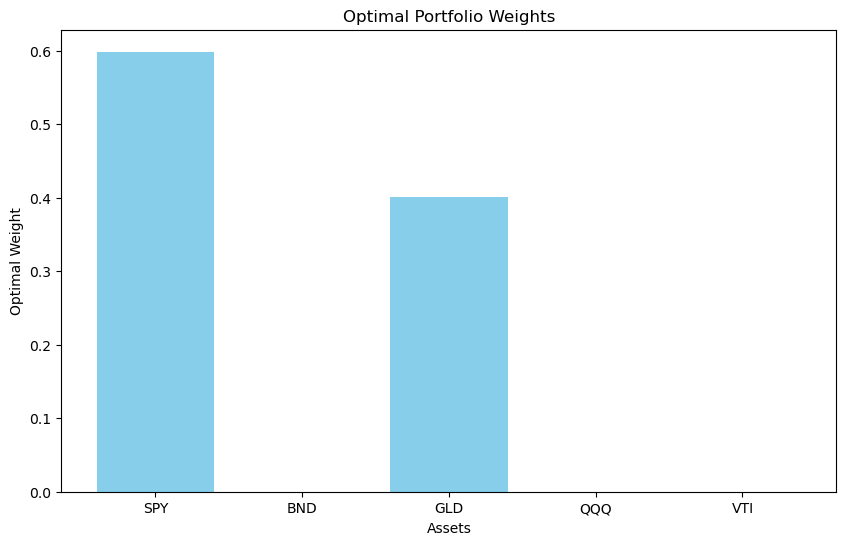

In [60]:
# display the final portfolio in a plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, color='skyblue')
plt.title('Optimal Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Optimal Weight')

plt.show()